In [1]:
import os
import glob
import datetime
import operator as op

import numpy             as np
import matplotlib.pyplot as plt

from CCutils    import  lmap
from CCutils    import npmap

from CCfun      import in_range
from CCfun      import datetime_from_spectrum

from CCplot     import plot1d
from CCplot     import auto_plot_style
from CCplot     import figure_sizes
from CCplot     import subplots

from CCfit      import fit
from CCfit      import        gauss
from CCfit      import triple_gauss

from CCio       import load_ccd_file

from CCdatabase import position_yield_zno

In [2]:
maindir = "/home/gonzalo/data/CC/position_dependence_ZnO_2020_01_19_15_27_39_422000/"

auto_plot_style({"lines.markersize" : 10})

In [3]:
def orderer(filename):
    basename = filename.split("/")[-1]
    tokens   = basename.split("_")
    index    = 0
    for token in tokens:
        if token[0].isdigit():
            index = 100 * index + int(token)
    return index

def sum_spectrum(em_wl, spectrum, plot=False):
    return np.sum(spectrum[in_range(em_wl, 400, 900)])

def integrate(em_wl, spectrum, plot=False):
    x, y = em_wl, spectrum
    seed = (1e10, 600, 30) * 3

    f = fit(triple_gauss, x, y, seed, fit_range=(400, 1000), maxfev=int(1e5))

    if plot:
        plot1d(x, y)
        plot1d(x, f.fn(x), "-")
        plot1d(x, gauss(x, *f.values[0:3]))
        plot1d(x, gauss(x, *f.values[3:6]))
        plot1d(x, gauss(x, *f.values[6:9]))

    params = sorted(f.values.reshape(3, 3), key=op.itemgetter(1))
    return np.concatenate(params), f.chi2

# Different positions in the wheel

In [4]:
positions = range(4, 12)

sums      = {}
integrals = {}

for pos in positions:
    filenames      = sorted(glob.glob(os.path.join(maindir, f"measurement_{pos}_*signal*")), key=orderer)
    datas          =  lmap(load_ccd_file, filenames)
    em_wls         =  lmap(op.attrgetter("em_wl"), datas)
    times          = npmap(datetime_from_spectrum, datas)
    times          = npmap(datetime.timedelta.total_seconds, times - times[0]) * 1.0
    spectra        = np.array([s.rate / s.power.mean for s in datas])
    params, chi2s  = map(np.array, map(list, zip(*map(integrate, em_wls, spectra))))
    integrals[pos] = params[:, ::3]
    sums     [pos] = npmap(sum_spectrum, em_wls, spectra)

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


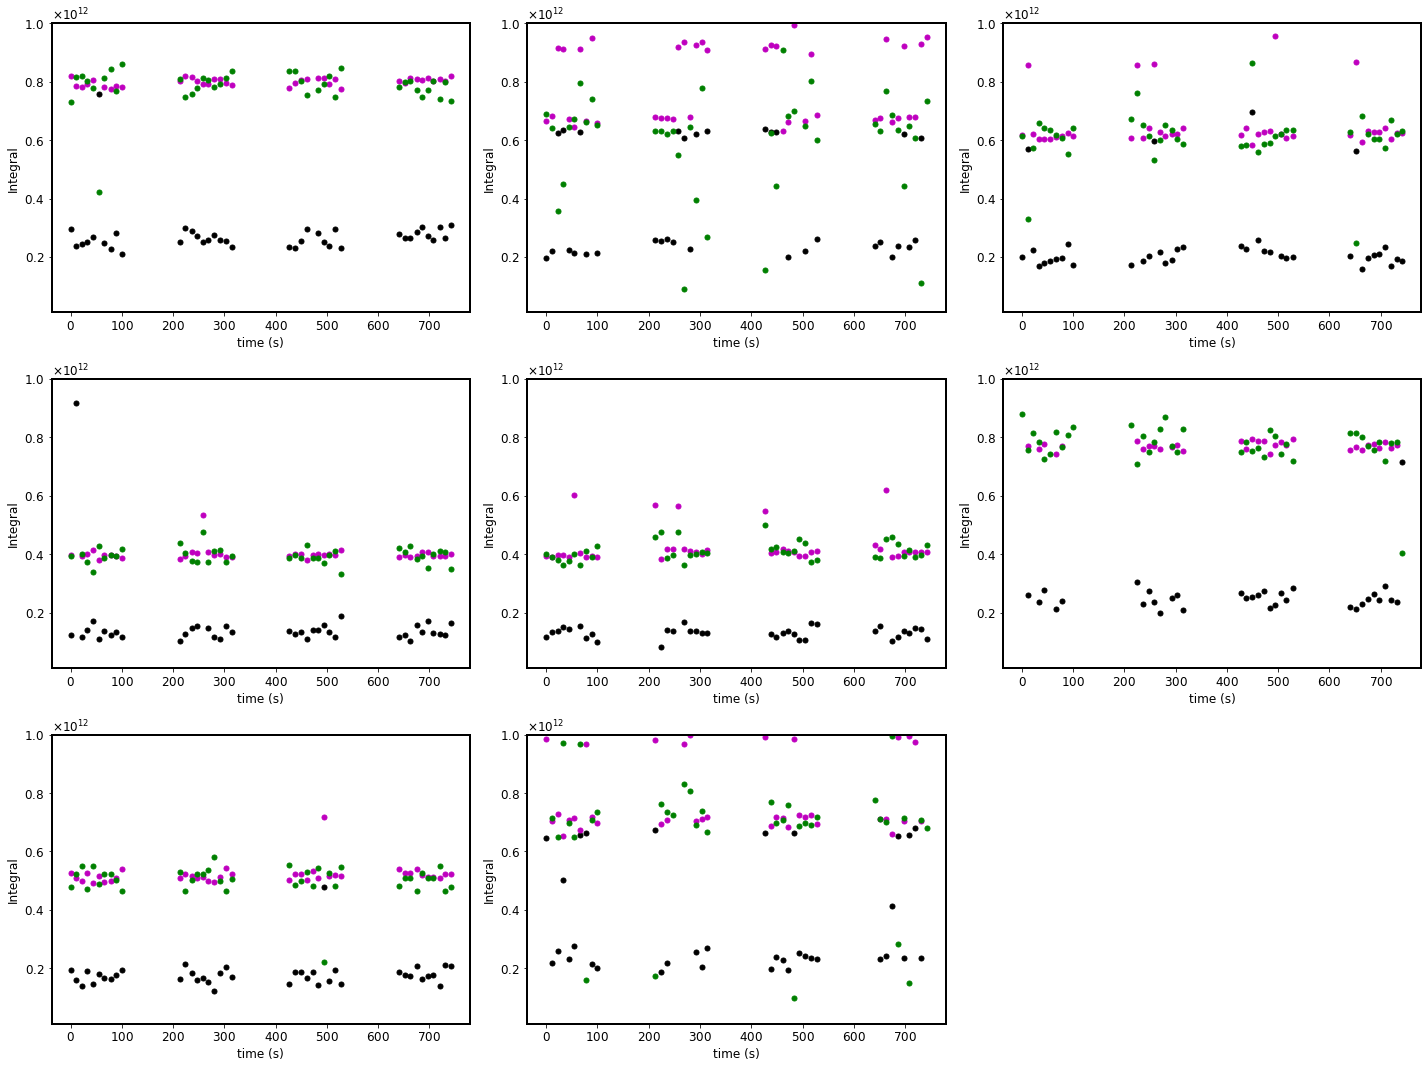

In [5]:
plt.figure(figsize=figure_sizes[len(positions)])
for pos in positions:
    plt.subplot(*subplots[len(positions)], pos - min(positions) + 1)
    plt.plot(times, integrals[pos], ".")
    plt.xlabel("time (s)")
    plt.ylabel("Integral")
    plt.ylim(1e10, 1e12)

plt.tight_layout()

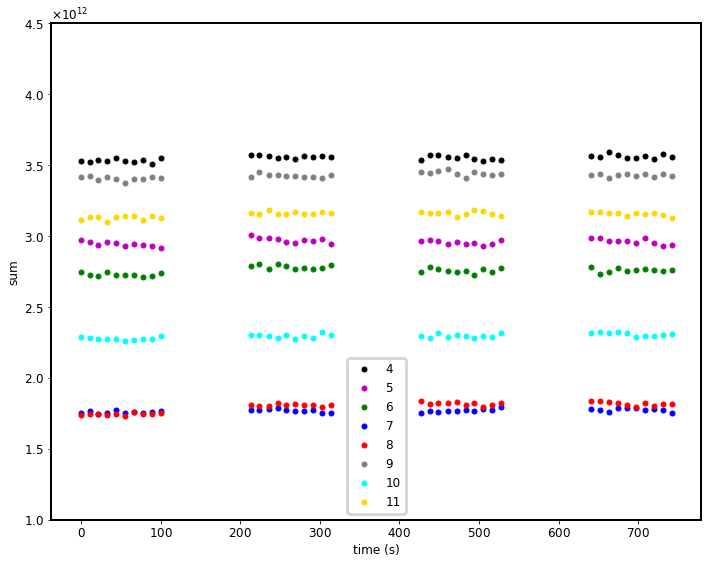

In [6]:
#plt.figure(figsize=figure_sizes[len(positions)])
for pos in positions:
    #plt.subplot(*subplots[len(positions)], pos - min(positions) + 1)
    plt.plot(times, sums[pos], ".", label=str(pos))
    plt.xlabel("time (s)")
    plt.ylabel("sum")
    plt.ylim(1e12, 4.5e12)

plt.legend()
plt.tight_layout()

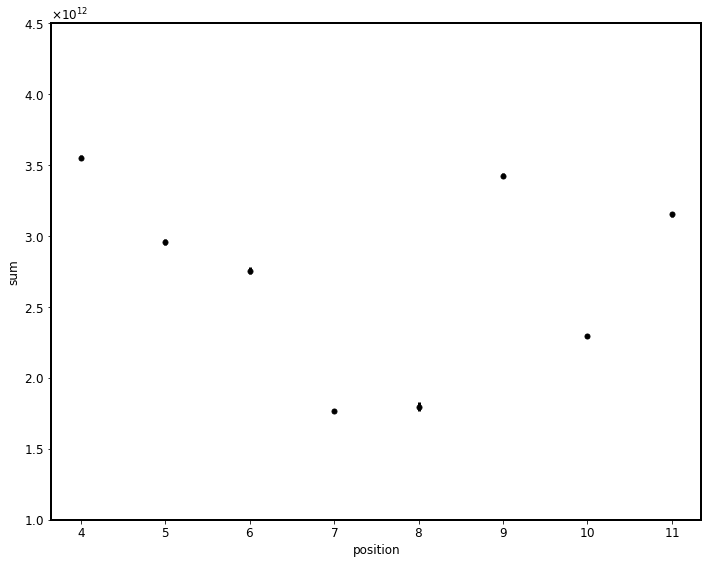

In [7]:
for pos in positions:
    plt.errorbar(pos, sums[pos].mean(), sums[pos].std(), fmt=".k")
    plt.xlabel("position")
    plt.ylabel("sum")
    plt.ylim(1e12, 4.5e12)

plt.tight_layout()

4 3551908311629.8047 1.0 0.005056438141703505
5 2958253869090.741 0.8328632412623671 0.005426321185468124
6 2756762498043.108 0.776135602660914 0.0066790535009492785
7 1769211624248.4062 0.498101715760956 0.003426611141329489
8 1798421168316.6184 0.5063253357154951 0.009043247039772663
9 3425966260380.6294 0.9645424261553119 0.005241493672474694
10 2295042775457.8525 0.6461435865175148 0.004664129842967054
11 3152799599572.8213 0.887635412561128 0.005377497936848583


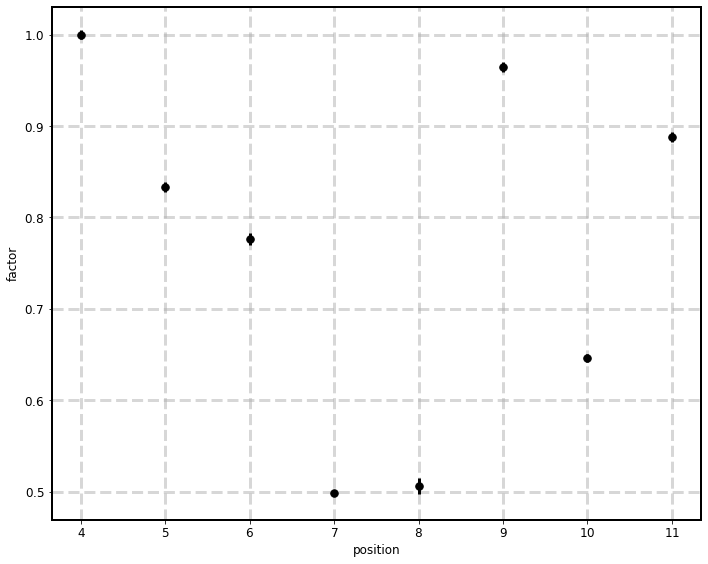

In [8]:
reference = max(s.mean() for s in sums.values())
for pos in positions:
    print(pos, sums[pos].mean(), sums[pos].mean()/reference, sums[pos].std()/reference)
    plt.errorbar(pos, sums[pos].mean()/reference, sums[pos].std()/reference, fmt=".k", markersize=15)
    plt.xlabel("position")
    plt.ylabel("factor")

plt.grid()
plt.tight_layout()

4 3551908311629.8047 1.0
5 2958253869090.741 0.8328632412623671
6 2756762498043.108 0.776135602660914
7 1769211624248.4062 0.498101715760956
8 1798421168316.6184 0.5063253357154951
9 3425966260380.6294 0.9645424261553119
10 2295042775457.8525 0.6461435865175148
11 3152799599572.8213 0.887635412561128


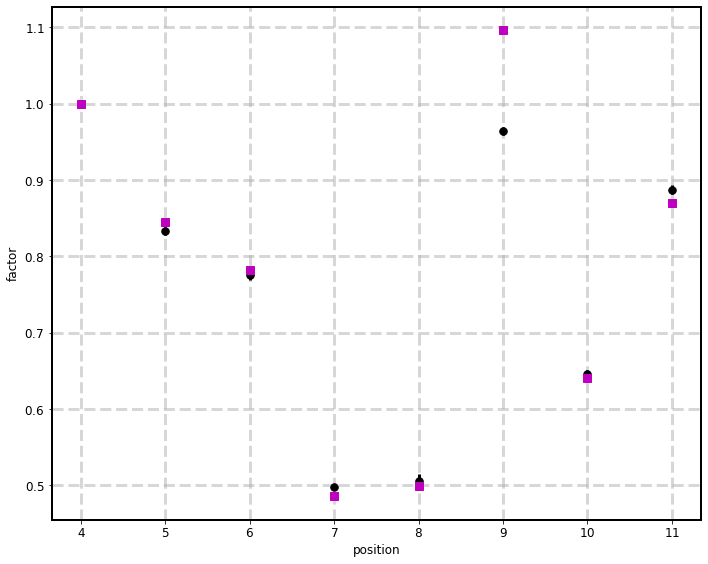

In [15]:
reference, index = max((s.mean(), pos) for pos, s in sums.items())
reference_zno    = position_yield_zno[index]

for pos in positions:
    print(pos, sums[pos].mean(),  sums[pos].mean() / reference)
    plt.errorbar(pos, sums              [pos].mean() / reference    , sums[pos].std()/reference, fmt=".k", markersize=15)
    plt.errorbar(pos, position_yield_zno[pos]        / reference_zno,                            fmt="sm", markersize= 8)
    plt.xlabel("position")
    plt.ylabel("factor")

plt.grid()
plt.tight_layout()

In [12]:
for i, v in sums.items():
    print(i, v/max(sums.values()))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()